# Project 1

## Imports, etc.

In [29]:
from quantumsolver import fewnucleonEmulator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy import stats
import emcee

## Task 1

### Define necessary constants, expermental data, etc.

In [129]:
# Define the size of our mesh
NcD = 256 #256
NcE = 256 #256

# Other constants
k=3
cbar=1
Q=0.33

In [130]:
# Experimental data: My
my_E3H=-8.482
my_E4He=-28.296
my_Rp4He=1.4552
my_fT3H=1129.6

# Experimental data: Sigma
sigma_E3H=0.015
sigma_E4He=0.005
sigma_Rp4He=0.0062
sigma_fT3H=3

### Evaluate with quantum solver

In [131]:
# Create a 2-dimensional grid
# cD el [-2.5, 2.5]
# cE el [-1, 1]
cD = np.linspace(start=-2.5, stop=2.5, num=NcD)
cE = np.linspace(start=-1, stop=1, num=NcE)
cD_eval, cE_eval = np.meshgrid(cD,cE)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(fewnucleonEmulator)
E4He_eval, Rp4He_eval, Rch4He_eval, E3He_eval, E3H_eval, E1A3H_eval, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)

### Define distributions

In [132]:
# --- Prior ---

def prior(cD, cE):
    prior_dist = stats.norm(0, 5)
    p1 = prior_dist.pdf(cD)
    p2 = prior_dist.pdf(cE)
    prior = np.outer(p2, p1)
    return prior

# --- Likelihood ---

def likelihood(data, my, sigma):
    likelihood_dist = stats.norm(my, sigma)
    likelihood = likelihood_dist.pdf(data)
    return likelihood

# --- Posterior ---

def posterior(cD, cE, data, my, sigma):
    p = prior(cD, cE)*likelihood(data, my, sigma)
    norm = np.trapz(np.trapz(p, cE, axis=1), cD)
    return p/norm

### Estimate model discrepancy

In [133]:
# Variance!
disc2_E3H = np.power(my_E3H*cbar*np.power(Q,k+1),2)/(1-Q**2)
disc2_E4He = np.power(my_E4He*cbar*np.power(Q,k+1),2)/(1-Q**2)
disc2_Rp4He = np.power(my_Rp4He*cbar*np.power(Q,k+1),2)/(1-Q**2)
disc2_fT3H = np.power(my_fT3H*cbar*np.power(Q,k+1),2)/(1-Q**2)

# square root of sum of squared standard error
sigma_E3H_efterr=np.sqrt(sigma_E3H**2+disc2_E3H)
sigma_E4He_efterr=np.sqrt(sigma_E4He**2+disc2_E4He)
sigma_Rp4He_efterr=np.sqrt(sigma_Rp4He**2+disc2_Rp4He)
sigma_fT3H_efterr=np.sqrt(sigma_fT3H**2+disc2_fT3H)

### Estimate Posterior

In [134]:
pE3H_noefterr = posterior(cD, cE, E3H_eval, my=my_E3H, sigma=sigma_E3H)
pE4He_noefterr = posterior(cD, cE, E4He_eval, my=my_E4He, sigma=sigma_E4He)
pRp4He_noefterr = posterior(cD, cE, Rp4He_eval, my=my_Rp4He, sigma=sigma_Rp4He)
pfT3H_noefterr = posterior(cD, cE, fT3H_eval, my=my_fT3H, sigma=sigma_fT3H)

pE3H_efterr = posterior(cD, cE, E3H_eval, my=my_E3H, sigma=sigma_E3H_efterr)
pE4He_efterr = posterior(cD, cE, E4He_eval, my=my_E4He, sigma=sigma_E4He_efterr)
pRp4He_efterr = posterior(cD, cE, Rp4He_eval, my=my_Rp4He, sigma=sigma_Rp4He_efterr)
pfT3H_efterr = posterior(cD, cE, fT3H_eval, my=my_fT3H, sigma=sigma_fT3H_efterr)

### Find a confidence interval

In [276]:
def credibility_interval(data, threshold=0.39):
    credibility_interval_width=threshold/2
    lb = np.percentile(data, 50 - 100 * credibility_interval_width)
    up = np.percentile(data, 50 + 100 * credibility_interval_width)
    return [lb, up]

def credibility_interval2(data, threshold=0.39):
    lb = np.percentile(data, 100 - 100 * threshold)
    return [lb, np.max(data)]

In [295]:
credibility_interval2(np.linspace(0,1,101), 0.39)

[0.61, 1.0]

In [296]:
credibility_interval(np.linspace(0,1,101), 0.39)

[0.305, 0.6950000000000001]

In [324]:
print(credibility_interval2(pE3H_noefterr, 0.3))
print(credibility_interval(pE3H_noefterr, 0.5))

[3.19125780138165e-310, 10.561838171251031]
[0.0, 1.0187675348903625e-216]


### Reproduce plot 6a

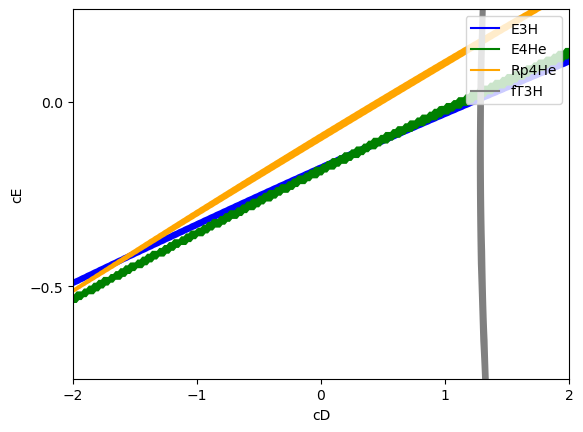

In [375]:
 # 6a)

# E4He_eval: blue
# E3H_eval: green
# Rp4He_eval: orange
# fT3H_eval: grey

plt.contourf(cD_eval, cE_eval, pE3H_noefterr, levels=credibility_interval2(pE3H_noefterr, 0.01), colors="blue", antialiased=True)
plt.contourf(cD_eval, cE_eval, pE4He_noefterr, levels=credibility_interval2(pE4He_noefterr, 0.01), colors="green", antialiased=True)
plt.contourf(cD_eval, cE_eval, pRp4He_noefterr, levels=credibility_interval2(pRp4He_noefterr, 0.01), colors="orange", antialiased=True)
plt.contourf(cD_eval, cE_eval, pfT3H_noefterr, levels=credibility_interval2(pfT3H_noefterr, 0.01), colors="grey", antialiased=True)

legend_labels = [
    mlines.Line2D([], [], color='blue', label='E3H'),
    mlines.Line2D([], [], color='green', label='E4He'),
    mlines.Line2D([], [], color='orange', label='Rp4He'),
    mlines.Line2D([], [], color='grey', label='fT3H')
]
plt.legend(handles=legend_labels)

plt.xlim([-2,2])
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel('cD')

plt.ylim([-0.75, 0.25])
plt.yticks([-0.5, 0])
plt.ylabel('cE')

# Show the plot
plt.show()

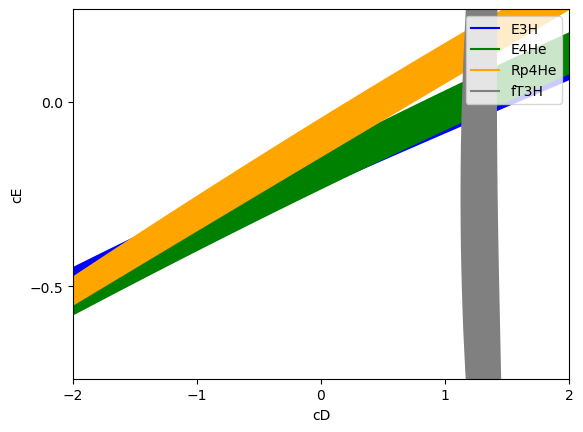

In [358]:
 # 6b)

# E4He_eval: blue
# E3H_eval: green
# Rp4He_eval: orange
# fT3H_eval: grey

plt.contourf(cD_eval, cE_eval, pE3H_efterr, levels=credibility_interval2(pE3H_efterr, 0.05), colors="blue", antialiased=True)
plt.contourf(cD_eval, cE_eval, pE4He_efterr, levels=credibility_interval2(pE4He_efterr, 0.05), colors="green", antialiased=True)
plt.contourf(cD_eval, cE_eval, pRp4He_efterr, levels=credibility_interval2(pRp4He_efterr, 0.05), colors="orange", antialiased=True)
plt.contourf(cD_eval, cE_eval, pfT3H_efterr, levels=credibility_interval2(pfT3H_efterr, 0.05), colors="grey", antialiased=True)

legend_labels = [
    mlines.Line2D([], [], color='blue', label='E3H'),
    mlines.Line2D([], [], color='green', label='E4He'),
    mlines.Line2D([], [], color='orange', label='Rp4He'),
    mlines.Line2D([], [], color='grey', label='fT3H')
]
plt.legend(handles=legend_labels)

plt.xlim([-2,2])
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel('cD')

plt.ylim([-0.75, 0.25])
plt.yticks([-0.5, 0])
plt.ylabel('cE')


# Show the plot
plt.show()

---

### Questions:

- How dense grid can you use given that each model evaluation takes $\lesssim 1$ ms and you would probably not like to wait more than $\sim$ minutes?

In [122]:
# Assume 1 minute => 60 seconds => 60,000 ms ~ 2^16 => 256x256 dimension

- There might be useful utility code in Problem Set 2 for extracting contour levels for a PDF that is evaluated on a grid.

- How many data points would you naively need to infer two model parameters? If you were to combine the data that you have available, which set do you think works best for this inference problem?

## Task 2

- Perform the inference using MCMC sampling (for example using the `emcee` package) and two different choices for the combined data likelihood that includes two (or four) observables:
  - Case 1: $\{E(^4\mathrm{He}), R_p(^4\mathrm{He})\}$
  - Case 2: $\{E(^4\mathrm{He}), R_p(^4\mathrm{He}), E(^3\mathrm{H}), fT(^3\mathrm{H})\}$
- Include the fixed EFT errors that were computed in the previous task.
- You can assume that all errors are independent, which implies that the total likelihood is just a product of the individual ones.
- Represent the results in a corner plot. I.e., you will basically reproduce the result in Fig. 3 in the paper (which is conditioned on all four observables, i.e., Case 2). Your parameter distribution will be somewhat different partly due to the fixed model discrepancy.

In [442]:
# --- logprior ---

def log_prior(cD, cE):
    prior_dist = stats.norm(0, 5)
    p1 = prior_dist.logpdf(cD)
    p2 = prior_dist.logpdf(cE)
    logprior = p1+p2
    return logprior

# --- loglikelihood ---

def log_likelihood(data, my, sigma):
    loglikelihood_dist = stats.norm(my, sigma)
    loglikelihood = loglikelihood_dist.logpdf(data)
    return loglikelihood

# --- logposterior ---

def log_posterior(cD, cE, data, my, sigma):
    # We can drop the normalization here. Otherwise:
    # p = prior(cD, cE)*likelihood(data, my, sigma)
    # norm = np.trapz(np.trapz(p, cE, axis=1), cD)
    # neglognorm = -np.log(norm)
    log_likelihoods = np.array(list(map(log_likelihood, data, my, sigma))).sum(0)
    return log_prior(cD, cE)+log_likelihoods

In [443]:
case1 = log_posterior(cD, cE, 
              data=[E4He_eval, Rp4He_eval], 
              my=[my_E4He, my_Rp4He], 
              sigma=[sigma_E4He_efterr, sigma_Rp4He_efterr])
case2 = log_posterior(cD, cE, 
              data=[E4He_eval, Rp4He_eval, E3H_eval, fT3H_eval], 
              my=[my_E4He, my_Rp4He, my_E3H, my_fT3H], 
              sigma=[sigma_E4He_efterr, sigma_Rp4He_efterr, sigma_E3H_efterr, sigma_fT3H_efterr])

In [ ]:
# https://cforssen.gitlab.io/tif285-book/content/BayesianStatistics/MaxEnt/demo-MaxEnt.html
# https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

ndim = 2  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take
ncorr = 100 # just keep every ncorr sample

# we'll start at random locations within the prior volume
np.random.seed(2020)
# cD el [-2.5, 2.5]
# cE el [-1, 1]
cD_start = 5 * np.random.rand(nwalkers,ndim) - 2.5
cE_start = 2 * np.random.rand(nwalkers,ndim) - 1

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prior, args=[logpr])

* Define functions for the `log_prior`, the `log_likelihood` and the `log_posterior`. The latter is provided as input to the `emcee` sampler. Note that the likelihood (and therefore the posterior) will depend on the choice of data set.
* Operating with log probabilities, the product of independent ones turns into a simple sum.
* `scipy.stats` provides a useful library for working with continuous variable distributions and for evaluating `logpdf`.
* It is probably worthwhile to test your `log_posterior` function before starting the MCMC sampling. 
* Consider beforehand how many samples you can afford to collect.
* The `show_titles=True` option to `corner` will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(y, [16, 50, 84], axis=0)` might be useful to extract numerical values for the credibility region and the median from a python array `y`.

## Task 3